# **Kings County House Price Prediction Project**



## **1.0 Business Overview**

This aim of this project is to utilize linear regression techiques to predict final house sale prices in King County in Washington State. This includes major cities such as Seattle and Redmond. The project is from the perspective of being hypothetically commissioned by a local realty company in Seattle to produce a model to accurately predict sale prices. The company will then use these results to more judiciously consider what clients it takes on as well as to appropriately set fees, rates, commissions, and the like.

### **1.1 Project Details**

For this project we'll be producing both 2 types of regression models.
- ***Inferential***: where we aim to understand how altering a feature affects the overall house price.
- ***Predictive***: where we simply aim to predict the house price as accurately as possible.

Our methodology for building models will will vary for each of these tasks.

### **1.2 Data**

- We utilized a dataset from the King County Assessor's public website, which lists house sale prices and other data for over 21,000 houses in the period from May 2014 - May 2015.

- We also manually scraped data from UnitedStatesZipCodes.org for a number of additional datapoints and features.

## **2.0 EDA**

### **2.1 Import initial libraries**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('drive/MyDrive/DS_Projects/kc_house_project/data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### **2.2 Data Cleaning**

We should check to see if the datastypes for each column makes sense as well as check for **missing values**.

In [3]:
# Checking for datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

***Quick Summary***
- The **ID** column can be dropped so can date as we are not doing time series analysis.
- We can also change **yr_renovated** to int64
- We also see that ***sqft_basement*** is an object rather than float

In [4]:
df = df.drop(['id', 'date'], axis = 1)

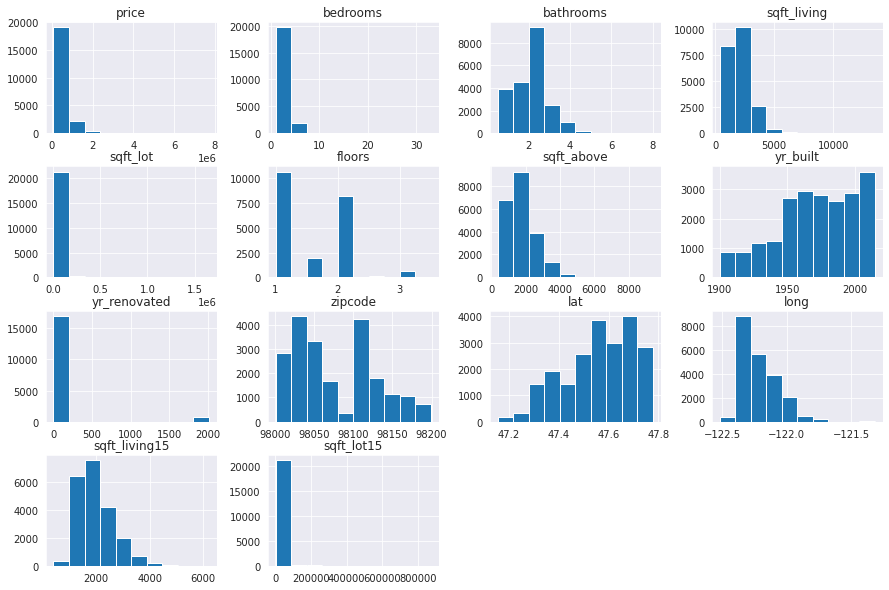

In [5]:
df.hist(figsize = (15,10));

Quick **summary**
- ***Outliers***: price, bedrooms, bathrooms, sqft_living, sqft_lot, sqft_above, sqft_living15, sqft_lot15

In [6]:
# Checking for na values
na_dict = dict(df.isna().sum())

na_list = []
for key, value in na_dict.items():
  if value > 0:
    na_list.append({'name': key, 'na_values': value})

# we see that these 3 columns have many missing values
na_list

[{'na_values': 2376, 'name': 'waterfront'},
 {'na_values': 63, 'name': 'view'},
 {'na_values': 3842, 'name': 'yr_renovated'}]

Let's look more into the missing values.

In [7]:
# investigating 'yr_renovated'
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64

We can see there are over 17,000 **0.0** values for year renovated. These represent houses that have not been renovated.

Rather than specifying the year, we can alter the column to simply be **0.0** if the house has not been renovated or 1.0 if it has been renovated.

In [8]:
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)
df['yr_renovated'].value_counts()

# Also change the column name
df = df.rename({'yr_renovated': 'renovated'}, axis = 1)

We still have missing na values. We'll fill those in with the modal value of 0 when we train test split.

In [9]:
# investigating 'waterfront'
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Here, there is a very large imbalance between NO and YES. Setting the missing values to NO is the safest bet. <br>
We will do this after doing train-test-split

In [10]:
# investigating 'view'
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Again, we can set the 63 missing values to the modal class, 'NONE'.<br>
Again, we will do this after train test split.

In [11]:
# investigating sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [12]:
df[df['sqft_basement'] != '?']['sqft_basement']

0          0.0
1        400.0
2          0.0
3        910.0
4          0.0
         ...  
21592      0.0
21593      0.0
21594      0.0
21595      0.0
21596      0.0
Name: sqft_basement, Length: 21143, dtype: object

The "?" values are NA values. We should decide what to replace these values with or drop them all together.

In [13]:
df[df['sqft_basement'] != '?']['sqft_basement'].astype(float)

0          0.0
1        400.0
2          0.0
3        910.0
4          0.0
         ...  
21592      0.0
21593      0.0
21594      0.0
21595      0.0
21596      0.0
Name: sqft_basement, Length: 21143, dtype: float64

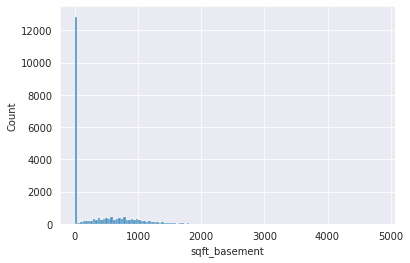

In [14]:
sns.histplot(data = df[df['sqft_basement'] != '?']['sqft_basement'].astype(float));

Again, the modal is clearly 0. We should apply the same logic and simply allocate the value of **'1'** for houses with a basement and **0** for those without a basement.This approach will also get rid of these outliers. We'll then use the modal value of 0 when we do our train test split.

In [15]:
# first convert the ? to np.nan
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: np.nan if x == '?' else x)

# then convert the column to a float column
df['sqft_basement'] = df['sqft_basement'].astype(float)

# and fianlly apply our lambda function
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else x)

We'll now have a look at the **sqft_lot** column.

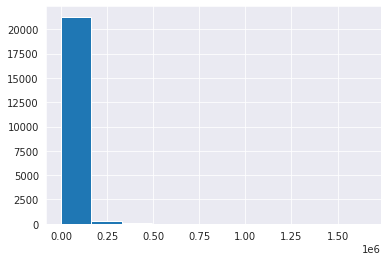

In [16]:
df['sqft_lot'].hist()

We can see very clear signs of outliers. Mainly after 250,000. We should see what proportion of the data has a sqft living value beyond 250000.

In [17]:
#we'll write a function to give us a quick summary of our outliers

def outlier_summary(df, column_name, threshold):
  len_outlier = len(df[df[column_name] > threshold])
  df_len = len(df)
  ratio = (len_outlier / df_len) * 100
  return print(f'percentage of outlier in data: {round(ratio, 3)}%')

In [18]:
outlier_summary(df, 'sqft_lot', 250000)

percentage of outlier in data: 0.491%


With only 0.49% of the total dataset, we may as well delete these rows.

In [19]:
df = df[df['sqft_lot'] < 250000]

Let's check our new distribution.

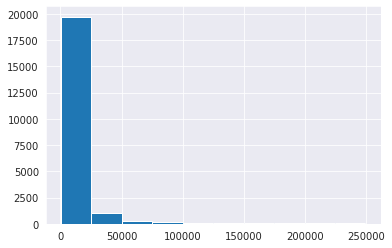

In [20]:
df['sqft_lot'].hist();

Well, it seems we again have very clear outliers. This time, beyond around 50,000.

In [21]:
outlier_summary(df, 'sqft_lot', 50000)

percentage of outlier in data: 3.606%


In [22]:
df = df[df['sqft_lot'] < 50000]

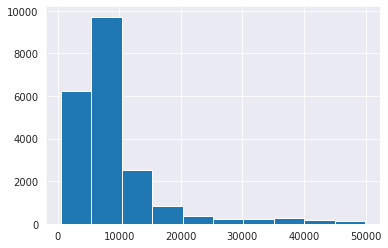

In [23]:
df['sqft_lot'].hist()

percentage of outlier in data: 3.881%


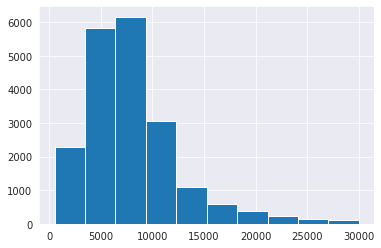

In [24]:
outlier_summary(df, 'sqft_lot', 30000)
df = df[df['sqft_lot'] < 30000]
df['sqft_lot'].hist()

Let's now have a look at the **sqft_lot15**.

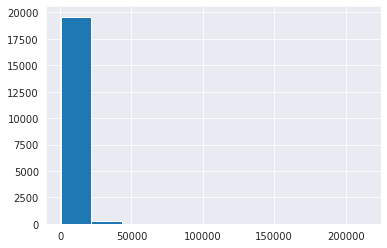

In [25]:
df['sqft_lot15'].hist();

We see a similar case with outliers after around 25,000. We'll perform the same actions as above.

In [26]:
outlier_summary(df, 'sqft_lot15', 25000)

percentage of outlier in data: 1.1%


This time the outliers represent 1% of the data. We can comfortably delete them.

In [27]:
df = df[df['sqft_lot15'] < 25000]

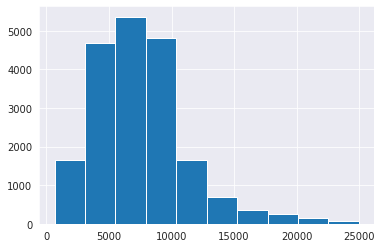

In [28]:
df['sqft_lot15'].hist();

We'll turn our attention to the **sqft_above** now.

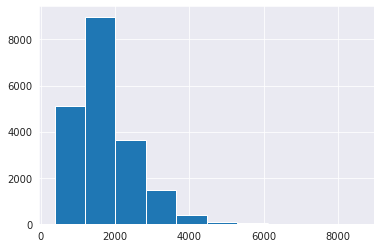

In [29]:
df['sqft_above'].hist();

Outliers after around 4000.

In [30]:
outlier_summary(df, 'sqft_above', 4000)

percentage of outlier in data: 1.198%


In [31]:
df = df[df['sqft_above'] < 4000]

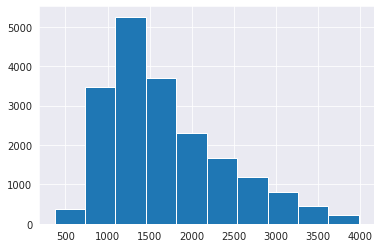

In [32]:
df['sqft_above'].hist();

Again for **sqft_living**.

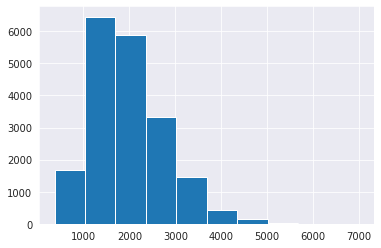

In [33]:
df['sqft_living'].hist();

In [34]:
outlier_summary(df, 'sqft_living', 5000)

percentage of outlier in data: 0.252%


In [35]:
df = df[df['sqft_living'] < 5000]

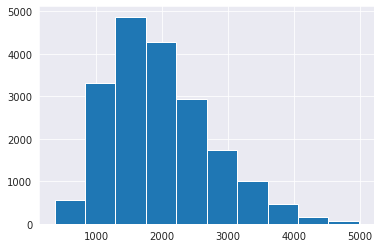

In [36]:
df['sqft_living'].hist();

We'll now look at number of **bedrooms**.

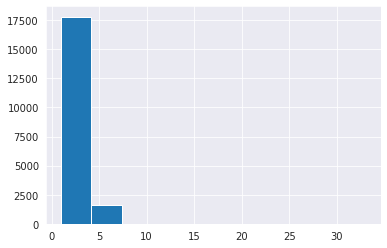

In [37]:
df['bedrooms'].hist();

It is ver uncommon to find a house with around 30+ bedrooms. This is most likely a data entry error.

In [38]:
df.sort_values(by = 'bedrooms', ascending = False)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,640000.0,33,1.75,1620,6000,1.0,NO,NONE,Very Good,7 Average,1040,1.0,1947,0.0,98103,47.6878,-122.331,1330,4700
8748,520000.0,11,3.00,3000,4960,2.0,NO,NONE,Average,7 Average,2400,1.0,1918,1.0,98106,47.5560,-122.363,1420,4960
19239,660000.0,10,3.00,2920,3745,2.0,NO,NONE,Good,7 Average,1860,1.0,1913,0.0,98105,47.6635,-122.320,1810,3745
13301,1150000.0,10,5.25,4590,10920,1.0,NO,AVERAGE,Average,9 Better,2500,1.0,2008,0.0,98004,47.5861,-122.113,2730,10400
15147,650000.0,10,2.00,3610,11914,2.0,NO,NONE,Good,7 Average,3010,1.0,1958,0.0,98006,47.5705,-122.175,2040,11914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6773,310000.0,1,0.75,520,2885,1.0,NO,NONE,Good,6 Low Average,520,0.0,1947,0.0,98117,47.6886,-122.378,980,4241
17404,290000.0,1,1.00,550,5700,1.0,NO,NONE,Fair,6 Low Average,550,0.0,1916,0.0,98117,47.6846,-122.366,1100,4560
264,369900.0,1,0.75,760,10079,1.0,YES,EXCELLENT,Very Good,5 Fair,760,0.0,1936,0.0,98070,47.4683,-122.438,1230,14267
7985,90000.0,1,1.00,780,4000,1.0,NO,NONE,Average,5 Fair,780,0.0,1905,NaN,98108,47.5424,-122.321,1150,4000


We shall make 2 amendements here.
- Change the entry of 33
- To make the distribution better, we should categorise the bedrooms in terms of number of bedrooms. 

In [39]:
# correct the 33 entry
df['bedrooms'] = df['bedrooms'].apply(lambda x: 3 if x == 33 else x)

In [40]:
# we give a rank 1 to houses with bedrooms between 0 and 3
# rank 2 for bedroom between 3 and 5
# rank 3 for bedroom greater than 5

def bedroom_rank(x):
  if x >= 0 and x <= 3:
    return 1
  elif x > 3 and x <= 5:
    return 2
  else:
    return 3  

In [41]:
df['bedrooms'] = df['bedrooms'].apply(lambda x: bedroom_rank(x))

Finally, we'll look at **bathrooms**.

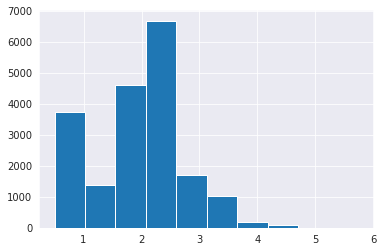

In [42]:
df['bathrooms'].hist();

In [43]:
outlier_summary(df = df, column_name = 'bathrooms', threshold = 5)
df = df[df['bathrooms'] < 5]

percentage of outlier in data: 0.031%


Finaly, we should now look at the distribution of the price column.

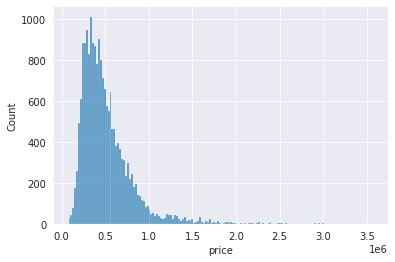

In [44]:
sns.histplot(data = df, x = 'price');

When we look at the graph above, we can see that the distribution is largely contained between 0 to 2,000,000. The graph exapands all the way out because of **outliers** <br>
Let's take a closer look at them.

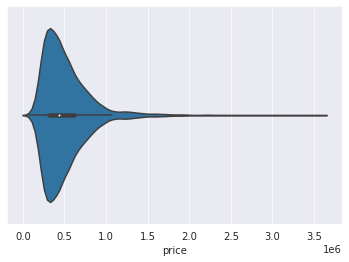

In [45]:
sns.violinplot(data = df, x = 'price');

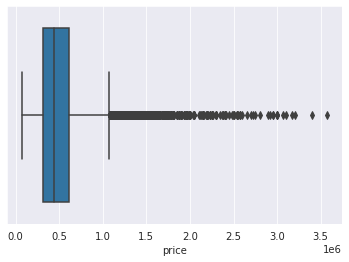

In [46]:
sns.boxplot(data = df, x = 'price');

With the violin & box plots, it is clear that we are dealing with outliers beyond 1.1 million USD.<br>
We can visualise the distribution of prices between 1.1m and the max amount.

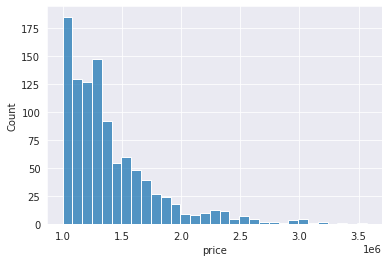

In [47]:
sns.histplot(data = df[(df['price'].between(1000000,9000000))], x = 'price')

In [48]:
# outliers beyond 3 million
len(df[df['price'] > 3000000])

6

As there are only 6 values beyond 3 million, we can delete them. <br>
We'll then make 2 separate datasets:
- one for modelling prices up to 1.1m
- the other to model between 1.1m and 4m

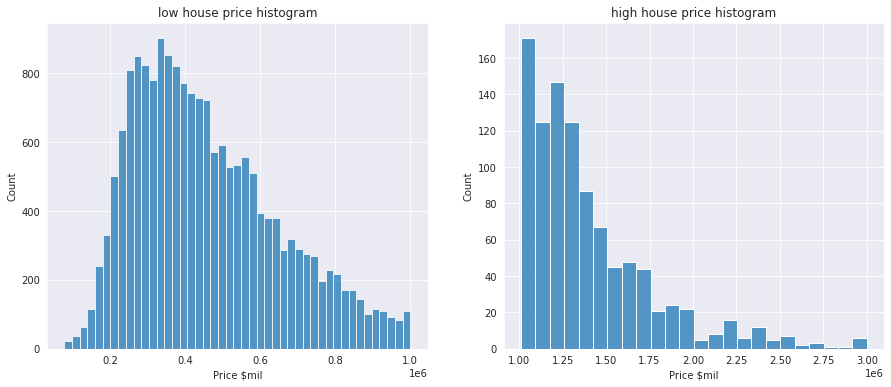

In [49]:
# 1st dataset
low_prices_df = df[df['price'].between(0, 1000000, inclusive = 'right')]

# 2nd dataset
high_prices_df = df[df['price'].between(1000000, 3000000, inclusive = 'right')]

# 1st dataset
f = plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
ax1 = sns.histplot(low_prices_df, x = 'price')
ax1.set_title('low house price histogram')
ax1.set_xlabel('Price $mil');

# 2nd dataset
plt.subplot(1, 2, 2)
ax2 = sns.histplot(high_prices_df, x = 'price')
ax2.set_title('high house price histogram')
ax2.set_xlabel('Price $mil');

**Quick Analysis:** whilst we see that the graph on the left is normally distributed, the prices show a **skewed distribution**. We should keep this in mind when modelling.

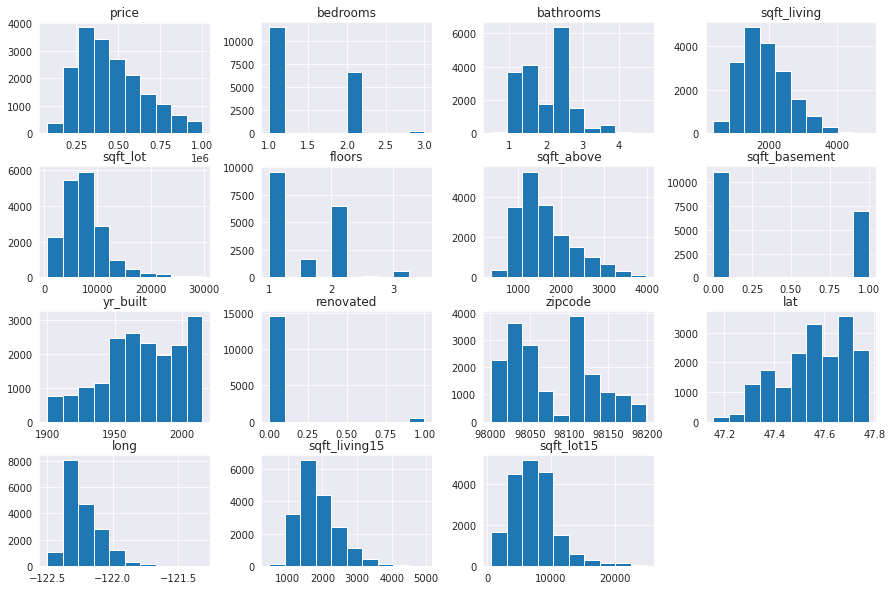

In [50]:
low_prices_df.hist(figsize = (15, 10));

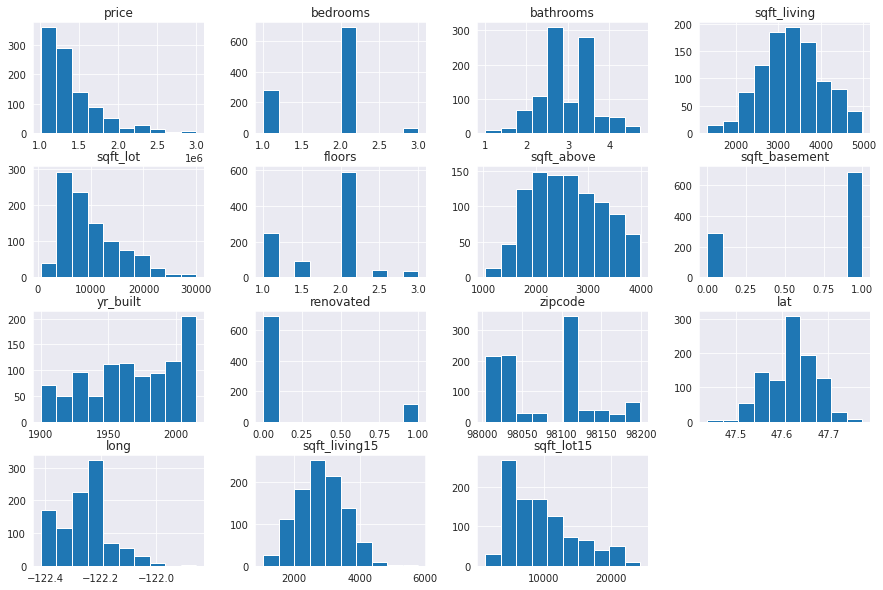

In [51]:
high_prices_df.hist(figsize = (15, 10));

## **3.0 Data Preparation**

### **3.1 Feature Engineering**
Now we are at a point where we can do some feature engineering for our dataset.

In [52]:
# average room size
low_prices_df['average_room_size'] = low_prices_df['sqft_living'] / (low_prices_df['bathrooms'] + low_prices_df['bedrooms'])

# floor area ratio
low_prices_df['floor_area_ratio'] = low_prices_df['sqft_living'] / low_prices_df['sqft_lot']

# bedroom - bathroom ratio
low_prices_df['bedroom_bathroom_ratio'] = low_prices_df['bathrooms'] / low_prices_df['bedrooms']


high_prices_df['average_room_size'] = high_prices_df['sqft_living'] / (high_prices_df['bathrooms'] + high_prices_df['bedrooms'])
high_prices_df['floor_area_ratio'] = high_prices_df['sqft_living'] / high_prices_df['sqft_lot']
high_prices_df['bedroom_bathroom_ratio'] = high_prices_df['bathrooms'] / high_prices_df['bedrooms']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

As we are dealing with longitude and lantitude information, we can make use of this within the business context.
A useful metric to calculate would be the distance from major cities i.e. **Redmond** and **Seattle**.

In [53]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(point1, point2):
    R = 6370
    lat1 = radians(point1[0])  #insert value
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def Redmond_Seattle_dist(df):
  # We will have to points of interest are the Centre of Seattle: (47.60457618602064, -122.32993003068658),
  # and the centre of Redmond: (47.679328831807894, -122.13055895937767)
  # For each record, we will calculate the distance from those points of interests and place them in a new column

  df['lat_long'] = list(zip(df['lat'], df['long']))
  df['Seattle_dist_km'] = df['lat_long'].apply(lambda x: get_distance(x, (47.60457618602064, -122.32993003068658)))
  df['Redmond_dist_km'] = df['lat_long'].apply(lambda x: get_distance(x, (47.679328831807894, -122.13055895937767)))

  # Finally we'll add the two together and form a new column
  df['Redmond_Seattle_total_dist'] = df['Seattle_dist_km'] + df['Redmond_dist_km']

  # The lat long column was temporary and only needed for the calculation. As it is a tuple, it is incompatible with sklearn
  # As such we shall drop it

  df.drop(columns=['lat_long'], inplace=True)
  
  return df

In [54]:
low_prices_df = Redmond_Seattle_dist(low_prices_df)
high_prices_df = Redmond_Seattle_dist(high_prices_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

We can also take this time to webscrape some additional information.

In [55]:
import json
import requests
from bs4 import BeautifulSoup
import re

In [56]:
zipcode_df = pd.DataFrame(columns=['zipcode', 'population', 'land_area', 'pop_density', 'water_area', 'income', 'nearby_schools'])

# We'll create a fucntion to webscrape all the unique zipcode values
def scrape_data(zipcode):
    # Setting up the web scraper
    headers = requests.utils.default_headers()
    headers.update({
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
    })

    url = f'https://www.unitedstateszipcodes.org/{zipcode}/'

    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.content, 'html.parser')
    pattern = '(?={"key":)(.*)(?=];var chart)'

    if len(soup.find_all('script')) == 46:
    
      # We'll firstly retrieve the populations    
      population_group_text = soup.find_all('script')[11].string.strip().replace('\t', '').replace('\n', '')
      population_group = json.loads(re.findall(pattern, population_group_text)[0])
      
      population = population_group['values'][-5]['y']
      
      # We'll then retrieve the area of the zipcode in square miles
      land_area = float(soup.find_all('td', class_='text-right')[4].get_text())
      
      # We can then find population density per year
      pop_density = population / land_area
      
      # The water area
      water_area = float(soup.find_all('td', class_='text-right')[5].get_text())
      
      # Average income per zipcode
      income_group_text = soup.find_all('script')[-16].string.strip().replace('\t', '').replace('\n', '')
      income_group = json.loads(re.findall(pattern, income_group_text)[0])
      income = income_group['values'][-5]['y']

      # Number of nearby schools in the zipcode
      nearby_schools = int(len(soup.find_all('div', class_='nearby-school')))
      
      # Then add them to the zipcode dataframe
      zipcode_dictionary = {'zipcode': zipcode,'population': population, 'land_area': land_area, 'pop_density': pop_density, 'water_area': water_area, 'income': income, 'nearby_schools': nearby_schools}
      
      return zipcode_dictionary
    
    else:
      print('no data found')

In [57]:
unique_zipcodes = list(pd.DataFrame(low_prices_df['zipcode'].value_counts()).reset_index()['index'])

In [58]:
scraped_zipcodes = [scrape_data(zipcode) for zipcode in unique_zipcodes]

no data found
no data found
no data found
no data found
no data found
no data found
no data found
no data found
no data found
no data found


In [65]:
cleaned_scraped_zipcodes = [zip for zip in scraped_zipcodes if zip != None]

In [66]:
scraped_zipcode_data = pd.DataFrame(cleaned_scraped_zipcodes)
scraped_zipcode_data.head()

,zipcode,population,land_area,pop_density,water_area,income,nearby_schools
0,98103,43690,4.64,9415.948276,0.66,92079.2947,12
1,98115,45920,6.58,6978.723404,2.11,109682.0867,18
2,98117,31850,3.94,8083.756345,0.61,102095.3462,7
3,98034,46310,9.13,5072.289157,1.69,90669.5548,16
4,98052,63200,20.10,3144.278607,0.83,128852.4797,18


In [67]:
#we'll save this as a csv so we don't have to keep rerunning the webscraping script
scraped_zipcode_data.to_csv('drive/MyDrive/DS_Projects/kc_house_project/data/scraped_data.csv')

Now, we should inner join this into our low and high price dataframes.

In [68]:
low_prices_df = low_prices_df.merge(scraped_zipcode_data, left_on = 'zipcode', right_on = 'zipcode')
high_prices_df = high_prices_df.merge(scraped_zipcode_data, left_on = 'zipcode', right_on = 'zipcode')

We'll quickly make a list of our continuous and categorical variables.

In [69]:
continuous_features = ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'average_room_size', 'floor_area_ratio', 'bedroom_bathroom_ratio',
                       'Seattle_dist_km', 'Redmond_dist_km', 'Redmond_Seattle_total_dist', 'population', 'land_area', 'pop_density', 'water_area', 'income']

categorical_features = ['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'renovated', 'zipcode', 'nearby_schools']

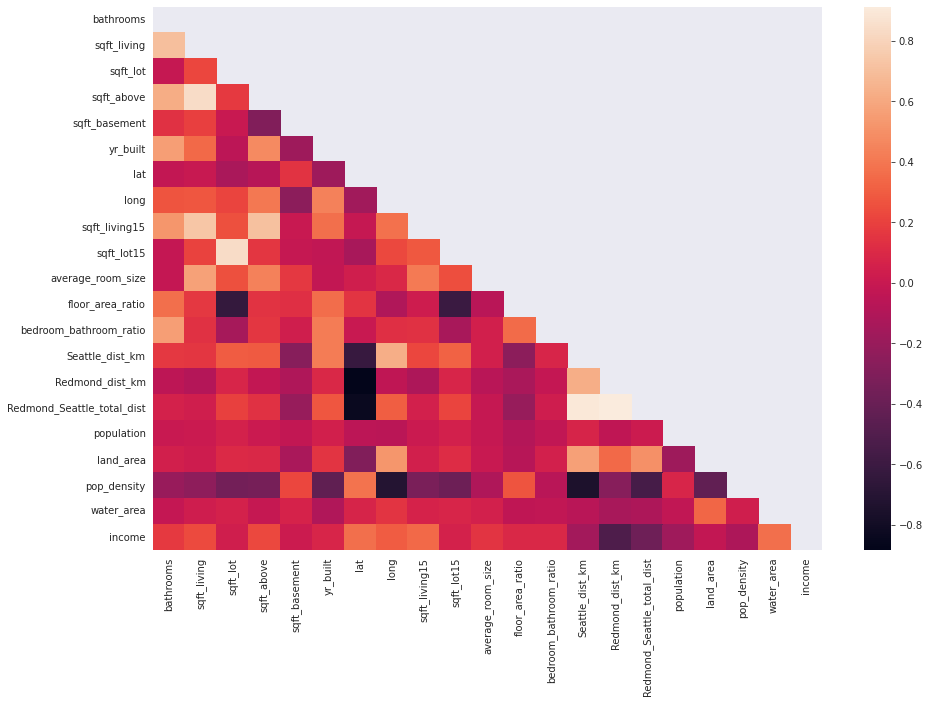

In [70]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(low_prices_df[continuous_features].corr(), mask = np.triu(low_prices_df[continuous_features].corr()));

We'll now save our 2 dataframes into 2 separate csv files so we can model them.

In [71]:
low_prices_df.to_csv('drive/MyDrive/DS_Projects/kc_house_project/low_prices_df.csv')
high_prices_df.to_csv('drive/MyDrive/DS_Projects/kc_house_project/high_prices_df.csv')